## Check for "new" reaquisition events

Use the derived residuals to check for any new intervals that would have caused new reacquisition events with a lower (5 arcsec) limit on residuals instead of 20 arcsecs.  To do that, I've gathered lists of dwells using:

 - Observations with AOKALSTR already low
 - Observations with onboard residuals between 5 and 20 arcsecs and low Kalman stars
 - Observations with derived residuals between 5 and 20 arcsecs and low Kalman stars


In [107]:
import numpy as np
from astropy.table import Table
import mica.quaternion
from Ska.quatutil import radec2eci
import agasc
from kadi import events
from Ska.engarchive import fetch
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from mica.starcheck import get_starcheck_catalog
from Chandra.Time import DateTime
import resids_and_kalstr

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Observations/dwells with AOKALSTR below 2 for more than 60 seconds.

In [3]:
# get_low_kalstr.py
#kalstr_obsids = []
#for year in range(2008, 2017):
#    dat = fetch.Msid('AOKALSTR', '{}:001'.format(year), '{}:001'.format(year+1))
#    lowkals = dat.logical_intervals('<=', '2 ')
#    lowkals = lowkals[lowkals['duration'] < 120]  # too-long intervals are spurious
#    bad = lowkals['duration'] > 60
#    lowkals = lowkals[bad]
#    for interval in lowkals:
#        ds = events.dwells.filter(start=interval['tstart'], stop=interval['tstop'])
#        kalstr_obsids.extend([d.get_obsid() for d in ds])
#
#kalstr_obsids = np.unique(kalstr_obsids)
#kalstr_obsids = kalstr_obsids[kalstr_obsids != 0]
#array([10345, 11804, 12317, 12332, 12357, 13295, 13483, 13651, 13788,
#       13822, 13927, 14219, 14279, 14333, 14399, 14457, 14507, 14524,
#       14557, 14603, 14902, 14961, 15129, 15149, 15175, 15177, 15180,
#       15215, 15217, 15228, 15272, 15292, 15304, 15349, 15487, 15616,
#       15642, 15658, 16311, 16314, 16350, 16368, 16369, 16630, 16632,
#       17026, 17321, 17707, 18113, 18231, 18719, 51717, 54181])

Observations (from onboard measurement residuals) which have stars with residuals between 5 and 20 arcsecs and and 8 consecutive samples (these have 4.1s sampling) where those stars could have brought the number of Kalman stars below 3. 

In [4]:
# from_res.py and times_to_dwells.py
#    yres_ok =  np.column_stack([np.abs(np.degrees(telem['AORESY{}'.format(slot)].vals)) * 3600 < 20
#                                for slot in range(0, 8)])
#    zres_ok =  np.column_stack([np.abs(np.degrees(telem['AORESY{}'.format(slot)].vals)) * 3600 < 20
#                             for slot in range(0, 8)])
#    yres_great =  np.column_stack([np.abs(np.degrees(telem['AORESY{}'.format(slot)].vals)) * 3600 < 5
#                             for slot in range(0, 8)])
#    zres_great =  np.column_stack([np.abs(np.degrees(telem['AORESY{}'.format(slot)].vals)) * 3600 < 5
#                                   for slot in range(0, 8)])
#
#    kalstr = telem['AOKALSTR'].vals.astype(int)
#    diff = np.sum((yres_ok != yres_great) | (zres_ok != zres_great), axis=1)
#    # find the intervals (with good onboard residual data) where the nonzero
#    # diff and low kalstr could have caused a problem.
#    for e in consecutive(np.flatnonzero(((kalstr - diff) < 3) & (diff != 0))):
#        if len(e) > 8:
#            low_t.append(DateTime(telem['AORESY0'].times[e[0]]).date)
#array([ 9836,  9931,  9943, 10008, 10289, 10822, 12315, 12952, 14333,
#       14530, 15003, 15129, 15149, 15292, 15308, 15670, 15724, 15804,
#       16177, 16190, 16311, 16314, 16350, 16452, 16501, 16629, 16734,
#       17026, 17208, 17321, 17494, 17596, 17706, 17707, 17765, 17881,
#       17896, 18241, 18353, 18446, 18619, 18629, 18781, 19505, 56341, 65535])

Get an independent list of observations based on their derived (AOCYAN/AOCZAN/AOATTQT) residuals

In [5]:
# from_derived.py
#        yag_offs[:, idx] = yag - pcad_data['AOACYAN{}'.format(entry['slot'])].vals
#        zag_offs[:, idx] = zag - pcad_data['AOACZAN{}'.format(entry['slot'])].vals
#    diff = np.sum(((np.abs(yag_offs) > 5) & (np.abs(yag_offs) < 20))
#                  | ((np.abs(zag_offs) > 5) & (np.abs(zag_offs) < 20)), axis=1)
#    kalstr = pcad_data['AOKALSTR'].vals.astype(int)
#    for e in consecutive(np.flatnonzero(((kalstr - diff) < 3) & (diff != 0))):
#        if len(e) > 8:
#            low_obsids.append(obsid)
#array([10008, 10289, 12135, 12315, 13111, 13391, 13822, 13846, 14048,
#       14461, 14465, 14926, 14993, 15003, 15129, 15151, 15192, 15216,
#       15804, 16065, 16177, 16311, 16314, 16345, 16473, 16630, 16662,
#       16734, 17208, 17321, 17556, 17706, 17707, 18227, 18353, 18446,
#       18619, 19386, 19942, 53365, 54323])


Dwell COBSRQID obsids don't always line up with starcheck catalog obsids, so a refined list is required to get more
accurate catalogs to use AOCYAN/AOCZAN/AOATTQT residuals.

In [6]:
dwells_to_check = Table.read("""cobsrqid, tstart, sc_obsid, mp_dir
9836, 322083894.208, 9836, /2008/MAR1008/oflsa/
9931, 350546588.916, 9931, /2009/FEB0909/oflsb/
9943, 362467466.609, 9943, /2009/JUN2209/oflsb/
10008, 350432063.61, 10008, /2009/FEB0209/oflsa/
10289, 360399418.306, 10289, /2009/JUN0109/oflsa/
10345, 364107983.291, 10345, /2009/JUL1009/oflsb/
10822, 361747514.773, 10822, /2009/JUN1509/oflsb/
11804, 370734202.723, 11804, /2009/SEP2809/oflsb/
12135, 386934513.042, 12135, /2010/APR0510/oflsa/
12315, 433980621.099, 12315, /2011/OCT0311/oflsa/
12317, 420529599.069, 12317, /2011/APR2911/oflsb/
12332, 423924481.245, 12332, /2011/JUN0811/oflsb/
12357, 420284542.056, 12357, /2011/APR2511/oflsa/
12952, 418365528.756, 12952, /2011/APR0311/oflsb/
13111, 416252507.547, 13111, /2011/MAR0611/oflsb/
13295, 470339544.79, 13295, /2012/NOV2312/oflsb/
13295, 470343566.89, 13295, /2012/NOV2312/oflsb/
13391, 429863519.783, 13391, /2011/AUG1511/oflsa/
13483, 474931200.637, 13483, /2013/JAN1413/oflsb/
13651, 445552297.496, 13651, /2012/FEB1312/oflsb/
13788, 477085189.053, 13788, /2013/FEB1113/oflsb/
13822, 443523219.689, 13822, /2012/JAN1612/oflsb/
13846, 453551274.92, 13846, /2012/MAY1412/oflsa/
13846, 453608679.023, 13846, /2012/MAY1412/oflsa/
13927, 473343573.951, 13927, /2012/DEC2412/oflsb/
14048, 462414469.864, 14048, /2012/AUG2012/oflsc/
14219, 490516166.581, 14219, /2013/JUL1513/oflsb/
14279, 464871284.296, 14279, /2012/SEP2212/oflsb/
14333, 431156946.851, 14333, /2011/AUG2711/oflsa/
14399, 490856966.8, 14399, /2013/JUL1813/oflsa/
14457, 490143628.261, 14457, /2013/JUL0813/oflsa/
14457, 490232540.866, 14457, /2013/JUL0813/oflsa/
14457, 490236972.966, 14457, /2013/JUL0813/oflsa/
14461, 458459248.853, 14461, /2012/JUL0712/oflsa/
14465, 459040173.784, 14465, /2012/JUL1612/oflsc/
14465, 459112538.788, 13728, /2012/JUL1612/oflsc/
14507, 469660642.153, 14507, /2012/NOV1912/oflsc/
14524, 495593098.458, 14524, /2013/SEP0913/oflsa/
14530, 483496379.9, 14530, /2013/APR2513/oflsb/
14557, 497797430.779, 14557, /2013/OCT0313/oflsa/
14557, 497798574.679, 14557, /2013/OCT0313/oflsa/
14557, 497800284.379, 14557, /2013/OCT0313/oflsa/
14557, 497800739.479, 14557, /2013/OCT0313/oflsa/
14603, 496535315.41, 14603, /2013/SEP2313/oflsa/
14902, 476684159.832, 14902, /2013/FEB0413/oflsa/
14926, 475945417.692, 14926, /2013/JAN2813/oflsa/
14961, 476489085.921, 14961, /2013/FEB0413/oflsa/
14993, 485812039.526, 14993, /2013/MAY2413/oflsa/
15003, 497566075.966, 15003, /2013/OCT0313/oflsa/
15129, 492754602.703, 15129, /2013/AUG1213/oflsa/
15129, 492765135.604, 15129, /2013/AUG1213/oflsa/
15129, 492770006.404, 15129, /2013/AUG1213/oflsa/
15149, 491028318.109, 15149, /2013/JUL1813/oflsa/
15149, 491079510.712, 15149, /2013/JUL1813/oflsa/
15151, 490255148.267, 15151, /2013/JUL1513/oflsb/
15175, 481887220.013, 15175, /2013/APR0813/oflsa/
15175, 481939732.816, 15175, /2013/APR0813/oflsa/
15177, 488225234.057, 15177, /2013/JUN1513/oflsa/
15180, 491755949.249, 15180, /2013/JUL2913/oflsa/
15192, 505422074.096, 15192, /2014/JAN0614/oflsb/
15192, 505514947.302, 15192, /2014/JAN0614/oflsb/
15215, 473985597.086, 15215, /2013/JAN0713/oflsa/
15216, 474687144.024, 15216, /2013/JAN1413/oflsb/
15217, 480431867.534, 15217, /2013/MAR1913/oflsa/
15228, 483713708.612, 15228, /2013/APR2913/oflsd/
15272, 477136500.556, 15272, /2013/FEB1113/oflsb/
15292, 500269845.714, 15292, /2013/NOV0413/oflsa/
15304, 482364312.439, 15304, /2013/APR0813/oflsa/
15304, 482370171.339, 15304, /2013/APR0813/oflsa/
15308, 494488664.998, 15308, /2013/AUG3113/oflsb/
15349, 471100935.331, 15349, /2012/DEC0312/oflsa/
15487, 486596484.368, 15487, /2013/MAY2513/oflsa/
15616, 478135420.51, 15616, /2013/FEB2513/oflsb/
15642, 519908772.995, 15642, /2014/JUN2314/oflsb/
15658, 488360689.864, 15658, /2013/JUN1513/oflsa/
15670, 514348127.188, 15670, /2014/APR1414/oflsb/
15724, 518949594.342, 15724, /2014/JUN0914/oflsa/
15804, 503949915.716, 15804, /2013/DEC1613/oflsb/
16065, 526905226.583, 16065, /2014/SEP0614/oflsb/
16065, 526918818.084, 16062, /2014/SEP0614/oflsb/
16177, 529191567.11, 16177, /2014/OCT0614/oflsa/
16190, 533073164.426, 16190, /2014/NOV1714/oflsc/
16311, 521247804.369, 16311, /2014/JUL0714/oflsc/
16314, 495189289.436, 16314, /2013/SEP0913/oflsa/
16314, 495196542.336, 16314, /2013/SEP0913/oflsa/
16314, 495198621.037, 16314, /2013/SEP0913/oflsa/
16314, 495200892.437, 16314, /2013/SEP0913/oflsa/
16314, 495205238.437, 16314, /2013/SEP0913/oflsa/
16314, 495212860.337, 16314, /2013/SEP0913/oflsa/
16314, 495218292.838, 16314, /2013/SEP0913/oflsa/
16314, 495231343.138, 16314, /2013/SEP0913/oflsa/
16314, 495232425.538, 16314, /2013/SEP0913/oflsa/
16314, 495241125.739, 16314, /2013/SEP0913/oflsa/
16314, 495263966.84, 16314, /2013/SEP0913/oflsa/
16314, 495269370.64, 16314, /2013/SEP0913/oflsa/
16314, 495277017.141, 16314, /2013/SEP0913/oflsa/
16314, 495301002.142, 16314, /2013/SEP0913/oflsa/
16345, 541885610.618, 16345, /2015/FEB2815/oflsa/
16350, 501305542.671, 16350, /2013/NOV1813/oflsa/
16368, 494506286.799, 16368, /2013/AUG3113/oflsb/
16368, 494548693.101, 16368, /2013/AUG3113/oflsb/
16369, 494381937.892, 16369, /2013/AUG3113/oflsb/
16369, 494411556.294, 16369, /2013/AUG3113/oflsb/
16452, 566345171.384, 16452, /2015/DEC1115/oflsb/
16473, 510343296.167, 16473, /2014/MAR0314/oflsa/
16501, 500298074.215, 16501, /2013/NOV0413/oflsa/
16629, 520651725.836, 16629, /2014/JUN3014/oflsb/
16630, 521037408.758, 16630, /2014/JUN3014/oflsb/
16632, 521734199.696, 16632, /2014/JUL1414/oflsb/
16662, 561552152.212, 16662, /2015/OCT1615/oflsa/
16734, 555241201.467, 16734, /2015/JUL2415/oflsb/
17026, 550520108.602, 17026, /2015/JUN1115/oflsa/
17208, 555577979.586, 17208, /2015/AUG1015/oflsa/
17321, 551670195.566, 17321, /2015/JUN2315/oflsa/
17321, 551680453.767, 17321, /2015/JUN2315/oflsa/
17321, 551685414.767, 17321, /2015/JUN2315/oflsa/
17494, 556223336.022, 17494, /2015/AUG1015/oflsa/
17556, 534557036.509, 17556, /2014/DEC0814/oflsd/
17596, 539982009.211, 17596, /2015/FEB0915/oflsc/
17706, 555397665.676, 17706, /2015/JUL2415/oflsb/
17707, 555471666.58, 17707, /2015/JUL2415/oflsb/
17765, 578833815.081, 17765, /2016/MAY0216/oflsb/
17881, 572400031.228, 17881, /2016/FEB0816/oflsb/
17896, 587127361.156, 17896, /2016/AUG0716/oflsb/
18113, 571325839.367, 18113, /2016/FEB0816/oflsb/
18227, 585199627.145, 18227, /2016/JUL1816/oflsa/
18231, 570155195.0, 18231, /2016/JAN2516/oflsa/
18241, 588872932.156, 18241, /2016/AUG2916/oflsa/
18353, 555823926.3, 18353, /2015/AUG1015/oflsa/
18446, 588141434.714, 18446, /2016/AUG1516/oflsa/
18619, 574536551.535, 18619, /2016/MAR1116/oflsb/
18629, 588434875.831, 18629, /2016/AUG2216/oflsb/
18719, 566119261.371, 18719, /2015/DEC0315/oflsa/
18781, 572696645.745, 18781, /2016/FEB2216/oflsb/
19386, 598466038.909, 19386, /2016/DEC1216/oflsa/
19505, 590472920.348, 19505, /2016/SEP1216/oflsa/
51717, 554532754.227, 51717, /2015/JUL2415/oflsb/
51717, 554538326.128, 51717, /2015/JUL2415/oflsb/
53365, 496714177.919, 53365, /2013/SEP2313/oflsa/
54181, 468616437.697, 54181, /2012/NOV0512/oflsa/
54181, 468619340.497, 54181, /2012/NOV0512/oflsa/
54323, 464250314.663, 54323, /2012/SEP1012/oflsa/
56341, 387258445.859, 56341, /2010/APR0510/oflsa/
65535, 447816088.016, 54793, /2012/MAR1012/oflsa/
""", format='ascii')

In [7]:
def consecutive(data, stepsize=1):
        return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

In [55]:
def start_of_low_event(times, kaldata, sim_moving):
    hit_time = 0
    hit_cnt = 0
    sim = False
    for e in consecutive(np.flatnonzero(kaldata < 2)):
        if (len(e) > 30 and sim_moving[e[0]] != 'T'):
            hit_time = times[e[0]]
            hit_cnt = len(e)
            break
        if (len(e) > 30 and sim_moving[e[0]] == 'T'):
            sim = True
    return hit_time, hit_cnt, sim

In [91]:
dwell_checks = []
for obs in dwells_to_check:
    check = {'tstart': obs['tstart'],
              'sc_obsid': obs['sc_obsid']}
    dwells = events.dwells.filter(start=obs['tstart'] - 5, stop=obs['tstart'] + 5)
    dwell = dwells[0]
    telem = resids_and_kalstr.get_telem(dwell)
    kalstr = telem['AOKALSTR'].vals.astype(int)
    in_kalm = telem['AOACASEQ'].vals == 'KALM'
    # searchsort this onto the AOKALSTR grid
    sim_moving = telem['3TSCMOVE'].vals[np.searchsorted(
                telem['3TSCMOVE'].times[1:-1], telem['AOKALSTR'].times) - 1]
    catalog = get_starcheck_catalog(obs['sc_obsid'], mp_dir=obs['mp_dir'])['cat']
    orig_times, orig_kal = resids_and_kalstr.kal(dwell, telem, limit=20, catalog=catalog, nowflags=False)
    # Check that my estimate is accurate
    check['frac_mismatch'] = 1.0 * np.count_nonzero(kalstr[in_kalm] - np.sum(orig_kal, axis=1)[in_kalm]) / len(kalstr[in_kalm])
    # Look for less-than-two-star intervals greater than 30 1.025 sec samples
    low_limit_times, low_limit_kal = resids_and_kalstr.kal(dwell, telem, limit=5, catalog=catalog, nowflags=False)
    # And do the same evaluation ignoring DP and MS even if the observation happened before those
    # flags were ignored
    new_limit_times, new_limit_kal = resids_and_kalstr.kal(dwell, telem, limit=5, catalog=catalog, nowflags=True)
    kal_ests = {'times': orig_times,
                'orig': np.sum(orig_kal, axis=1),
                'low_limit': np.sum(low_limit_kal, axis=1),
                'new_low_limit': np.sum(new_limit_kal, axis=1)}
    for t in ['orig', 'low_limit', 'new_low_limit']:
        hit_time, hit_cnt, sim = start_of_low_event(kal_ests['times'], kal_ests[t], sim_moving)
        check['{}_hit_time'.format(t)] = hit_time
        check['{}_hit_cnt'.format(t)] = hit_cnt
        check['{}_sim'.format(t)] = sim
    dwell_checks.append(check)

In [95]:
dwell_checks = Table(dwell_checks)

In [98]:
has_hit = dwell_checks['low_limit_hit_time'] != 0

In [103]:
dwell_checks[has_hit][['sc_obsid', 'frac_mismatch', 'orig_hit_time', 'low_limit_hit_time', 'new_low_limit_hit_time', 'low_limit_sim']]

sc_obsid,frac_mismatch,orig_hit_time,low_limit_hit_time,new_low_limit_hit_time,low_limit_sim
int64,float64,float64,float64,int64,bool
13295,0.000517866390471,470343472.59,470343472.59,0,False
13846,1.79221105077e-05,0.0,453608422.773,0,False
14457,0.000115361543076,490232448.616,490232448.616,0,False
14461,5.99460485563e-05,458510513.206,458510509.106,0,False
14465,4.50572226728e-05,459085639.712,459085624.337,0,False
14557,0.00189393939394,497798482.429,497798482.429,0,False
14557,0.0,497800190.079,497800190.079,0,False
14557,0.0,497800645.179,497800645.179,0,False
14993,0.00094816687737,485815251.876,485815248.801,0,False


In [100]:
has_different_hit = ((dwell_checks['low_limit_hit_time'] != 0)
                     & (dwell_checks['low_limit_hit_time'] != dwell_checks['orig_hit_time']))

In [102]:
dwell_checks[has_different_hit][['sc_obsid', 'frac_mismatch', 'orig_hit_time', 'low_limit_hit_time', 'new_low_limit_hit_time', 'low_limit_sim']]

sc_obsid,frac_mismatch,orig_hit_time,low_limit_hit_time,new_low_limit_hit_time,low_limit_sim
int64,float64,float64,float64,int64,bool
13846,1.79221105077e-05,0.0,453608422.773,0,False
14461,5.99460485563e-05,458510513.206,458510509.106,0,False
14465,4.50572226728e-05,459085639.712,459085624.337,0,False
14993,0.00094816687737,485815251.876,485815248.801,0,False
16630,0.0025378758748,0.0,521077120.335,0,False


Two observations, 13846 and 16630, show evidence in this search that they would have had a "new" reacquisition event if the lower limit had been in use at the time of their observation.  More research shows that both of these events occur at the end of these observations and that obsid 16630 actually ended in a non-scs107 SIM transition caused by a commanding error and 13846 ended in SCS107.  In those cases, it just looks like the 3TSCPOS/3TSCMOVE value in telemetry was updated a little late to get caught by my sim_moving check.

Observations 14461, 14465, and 14993 also ended in SCS107 not caught by my sim moving check.


(734696.83352195483, 734696.83407953591)

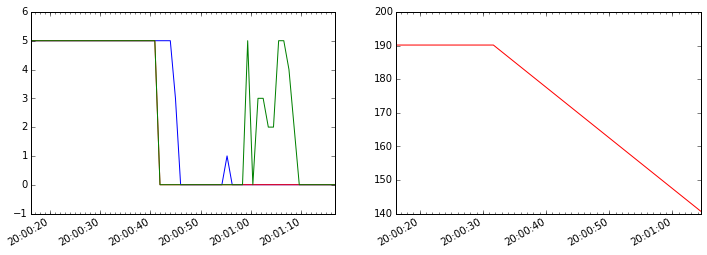

In [130]:
# but why don't I see a new_low_limit hit for these observations
obsid = 14461
obs = dwells_to_check[dwells_to_check['sc_obsid'] == obsid][0]
dwells = events.dwells.filter(start=obs['tstart'] - 5, stop=obs['tstart'] + 5)
dwell = dwells[0]
telem = resids_and_kalstr.get_telem(dwell)
kalstr = telem['AOKALSTR'].vals.astype(int)
in_kalm = telem['AOACASEQ'].vals == 'KALM'
# searchsort this onto the AOKALSTR grid
sim_moving = telem['3TSCMOVE'].vals[np.searchsorted(
            telem['3TSCMOVE'].times[1:-1], telem['AOKALSTR'].times) - 1]
catalog = get_starcheck_catalog(obs['sc_obsid'], mp_dir=obs['mp_dir'])['cat']
orig_times, orig_kal = resids_and_kalstr.kal(dwell, telem, limit=20, catalog=catalog, nowflags=False)
# Check that my estimate is accurate
# Look for less-than-two-star intervals greater than 30 1.025 sec samples
low_limit_times, low_limit_kal = resids_and_kalstr.kal(dwell, telem, limit=5, catalog=catalog, nowflags=False)
# And do the same evaluation ignoring DP and MS even if the observation happened before those
# flags were ignored
new_limit_times, new_limit_kal = resids_and_kalstr.kal(dwell, telem, limit=5, catalog=catalog, nowflags=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_cxctime(telem['AOKALSTR'].times, kalstr, 'b', ax=axes[0])
plot_cxctime(low_limit_times, np.sum(low_limit_kal, axis=1), 'r', ax=axes[0])
plot_cxctime(new_limit_times, np.sum(new_limit_kal, axis=1), 'g', ax=axes[0])
axes[0].set_xlim(xmin=cxctime2plotdate([new_limit_times[-60]])[0])
axes[0].set_ylim(-1, 6)
plot_cxctime(telem['3TSCPOS'].times, telem['3TSCPOS'].vals, 'r') # just connect the dots for this plot
axes[1].set_xlim(xmin=cxctime2plotdate([new_limit_times[-60]])[0])


It looks like this doesn't show up as exceeding 30 samples with less than 2 Kalman stars in the "new_low_limit" case because the estimate of the number of stars pops up again (green on plots) during the SCS107.  A closer look at DP and MS flag data for the observation shows that the DP and MS flags are both set during different periods of time on all stars during this phase of the end of the observation.

I don't quite understand the ACA processing at this point anyway, so I think this is moot, but if we need to be worried about Kalman star disruption during SCS107 this could get some more attention.